# Travel Insurance predictions

A Tour & Travels company is offering a travel insurance package to their customers, which now includes Covid Cover. This insurance was offered to some customers in 2019, and the provided data has been extracted from the performance and sales of the package during that period.

## Objectives
- Identify the most accurate model based on business needs.
- Provide business recommendations on targeting individuals for the special Covid Cover travel insurance plan.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from functions import (train_random_forest, evaluate_model, plot_feature_importances, download_kaggle_dataset,
                       plot_precision_recall_curve, create_custom_colormap,
                       plot_confusion_matrix, perform_paired_t_test, display_classification_report)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

## Data import

In [2]:
download_kaggle_dataset('tejashvi14/travel-insurance-prediction-data')
data = pd.read_csv('data/TravelInsurancePrediction.csv')
print("Total number of observations:", len(data))
data.head()

Dataset URL: https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data
Total number of observations: 1987


,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Dataset consists of:
- **Unnamed: 0** - An index column which will not be needed for ML models
- **Age** - Age Of The Customer
- **Employment Type** - The Sector In Which Customer Is Employed
- **GraduateOrNot** - Whether The Customer Is College Graduate Or Not
- **AnnualIncome** - The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees]
- **FamilyMembers** - Number Of Members In Customer's Family
- **ChronicDisease** - Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc.
- **FrequentFlyer** - Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years[2017-2019].
- **EverTravelledAbroad** - Has The Customer Ever Travelled To A Foreign Country[Not Necessarily Using The Company's Services]
- **TravelInsurance** - Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019.

## Data cleaning

- Removing unnecessary columns

In [3]:
data.drop(columns=['Unnamed: 0'], inplace=True)

- Checking if there are any missing values

In [4]:
print("Missing values in each column:\n", data.isnull().sum())

Missing values in each column:
 Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64


- There are no missing values.  

- Now will calculate the number of duplicates as well as number of pairs or groups of duplicates

In [5]:
total_duplicate_rows = data.duplicated(keep=False).sum()
duplicate_pairs = data[data.duplicated()].drop_duplicates().shape[0]

if total_duplicate_rows > 0:
    print(f"Number of pairs/groups of duplicates: {duplicate_pairs}")
    print(f"Total number of duplicate rows: {total_duplicate_rows}")
else:
    print("There are no duplicate observations where all column values are exactly the same.")

Number of pairs/groups of duplicates: 382
Total number of duplicate rows: 1120


- There's a significant number of duplicates and duplicate groups.
- Will visualize how count of these groups distributes

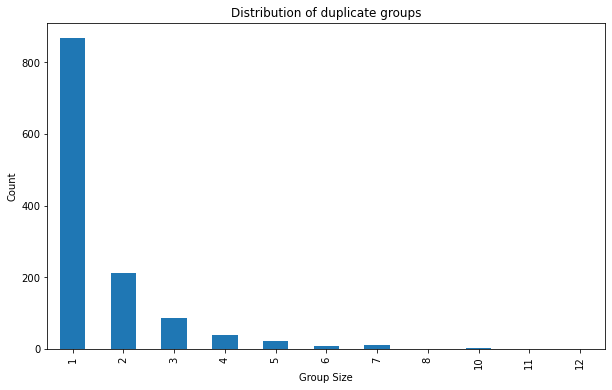

In [6]:
row_counts = data.value_counts()
duplicates = row_counts[row_counts > 1]
distribution = duplicates.value_counts().sort_index()
distribution = distribution.append(pd.Series([data.shape[0] - duplicates.sum()], index=[1]))
distribution = distribution.sort_index()

plt.figure(figsize=(10, 6))
distribution.plot(kind='bar')
plt.xlabel('Group Size')
plt.ylabel('Count')
plt.title('Distribution of duplicate groups')
plt.show()

- Due to small size of the dataset it's too risky to blindly drop duplicate rows. 
- It's not specified whether these were same individuals with multiple entries or it's different people with identical backgrounds.
- Due to the reasons above, ML models will be trained on both: original data and deduplicated data.

- Before EDA, we need to identify any illogical rows. Specifically, we'll check for entries where participants are marked as frequent flyers but also indicate they've never travelled abroad.

In [7]:
if not data[(data['FrequentFlyer'] == 1) & (data['EverTravelledAbroad'] == 'No')].empty:
    print(data[(data['FrequentFlyer'] == 1) & (data['EverTravelledAbroad'] == 'No')])
else:
    print("There are no such rows where FrequentFlyer is 'Yes' and EverTravelledAbroad is 'No'.")

There are no such rows where FrequentFlyer is 'Yes' and EverTravelledAbroad is 'No'.


In [8]:
data.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


- The table shows that the dataset contains **1987 entries**. 
- Participants' **ages** range from **25** to **35** years.
- **Annual incomes** vary widely from **300,000** to **1,800,000**.
- **Family sizes** range from **2** to **9** members. 
- Most participants do not have **chronic diseases**, as indicated by the mean of **0.28**.
- Similar trend is observed with **travel insurance**, where a significant portion of the participants do not have it, as shown by the mean of **0.36**.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


- No null values in any of the columns
- Some features will need to be converted to integer for ML

## EDA

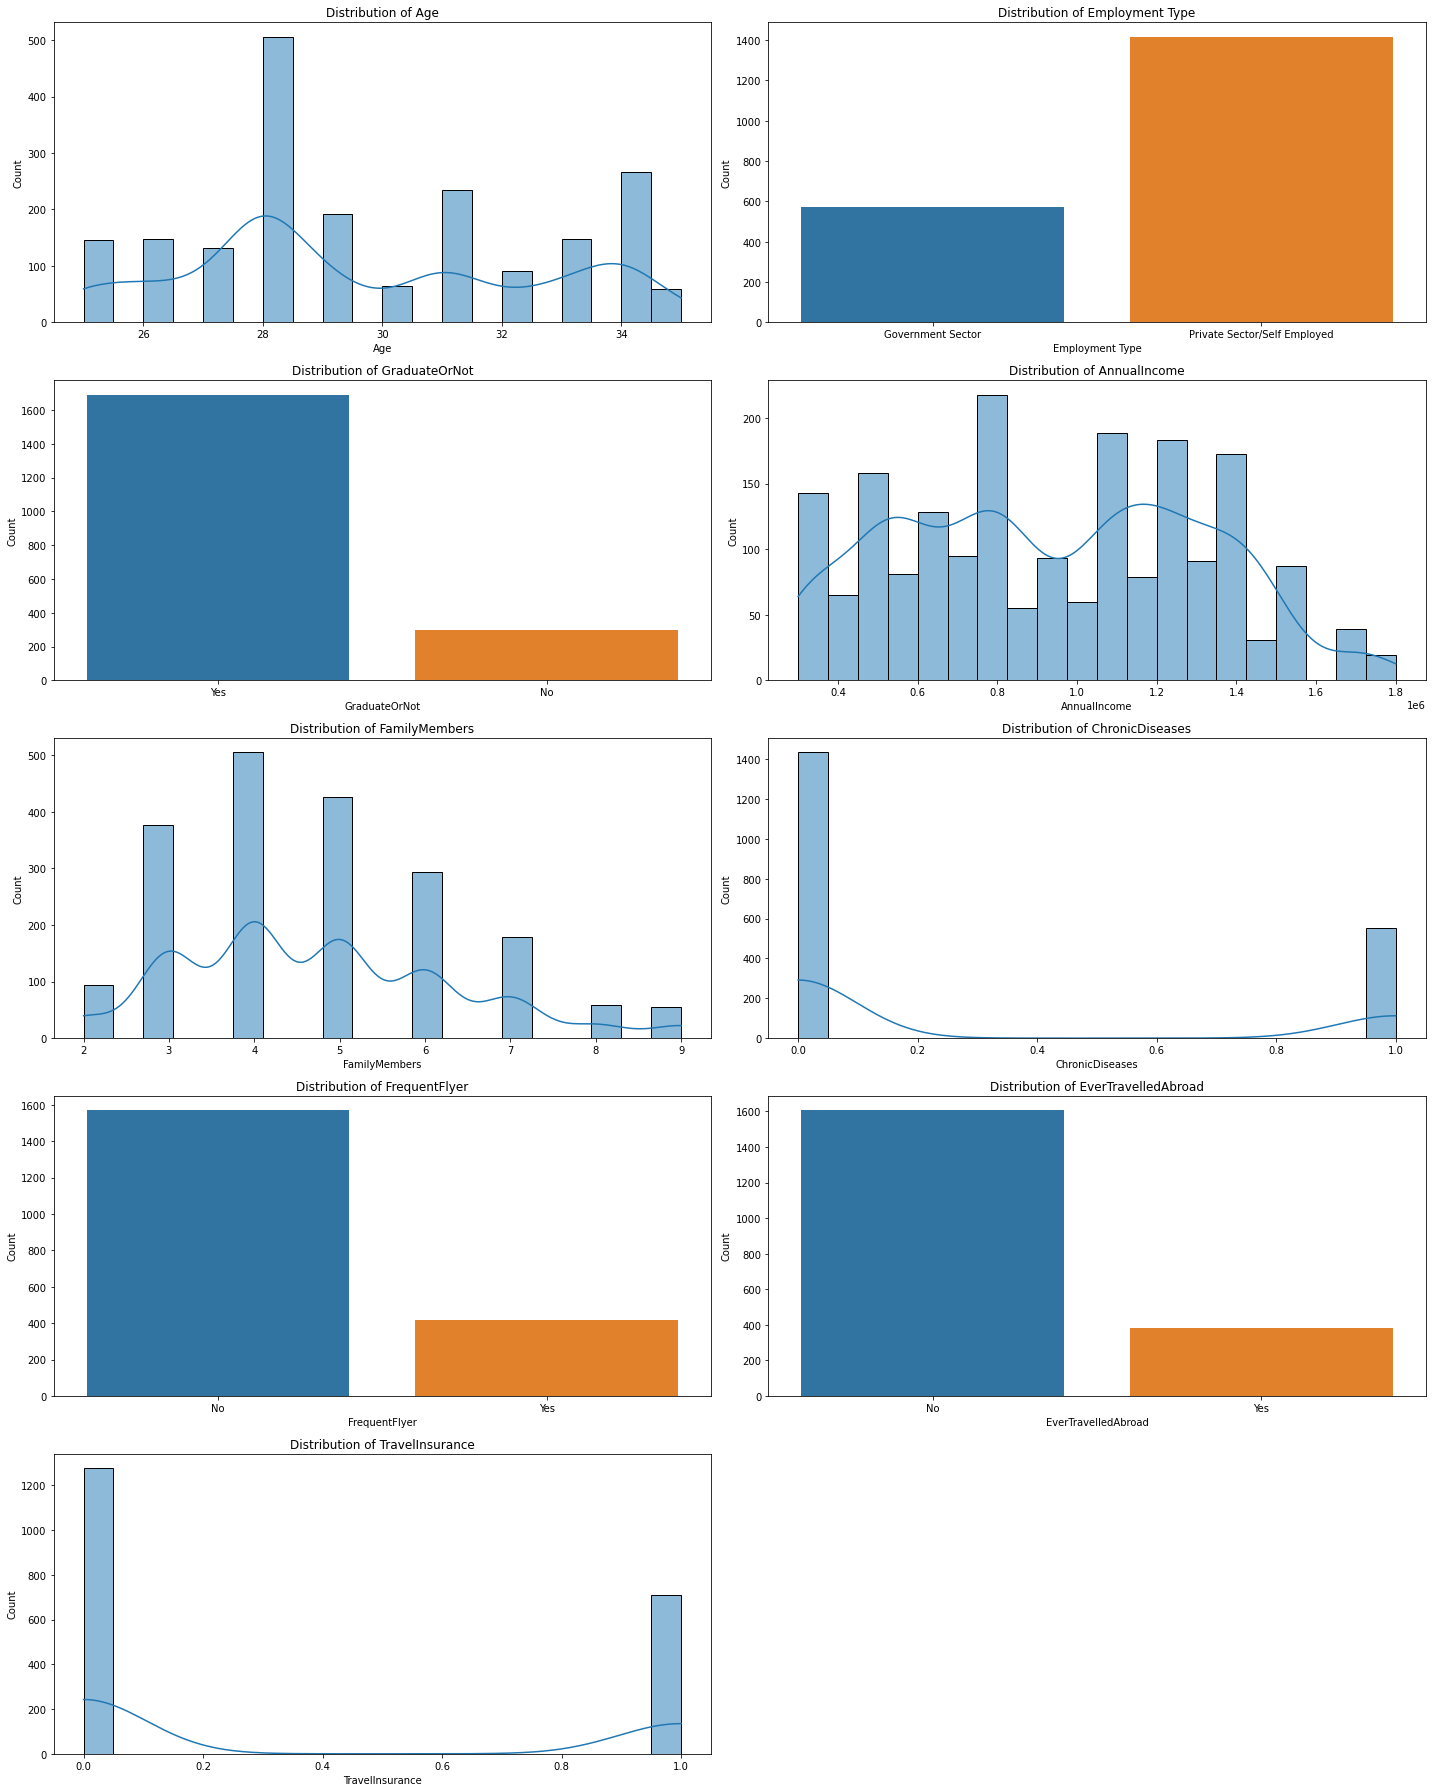

In [10]:
num_rows = math.ceil(len(data.columns) / 2)
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    ax = axes[i]
    if data[column].dtype == 'object':
        sns.countplot(data=data, x=column, ax=ax)
    else:
        sns.histplot(data=data, x=column, bins=20, kde=True, ax=ax)
    
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
print(data.select_dtypes(include=['object']).columns.tolist())

['Employment Type', 'GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']


- These features need to be converted to numerical.
- Features with Yes/No answers will be converted to 1/0

In [12]:
data['GraduateOrNot'] = data['GraduateOrNot'].apply(lambda x: 1 if x == 'Yes' else 0)
data['FrequentFlyer'] = data['FrequentFlyer'].apply(lambda x: 1 if x == 'Yes' else 0)
data['EverTravelledAbroad'] = data['EverTravelledAbroad'].apply(lambda x: 1 if x == 'Yes' else 0)
data['Employment Type'] = data['Employment Type'].apply(lambda x: 1 if x == 'Private Sector/Self Employed' else 0)

print(data.dtypes)

Age                    int64
Employment Type        int64
GraduateOrNot          int64
AnnualIncome           int64
FamilyMembers          int64
ChronicDiseases        int64
FrequentFlyer          int64
EverTravelledAbroad    int64
TravelInsurance        int64
dtype: object


In [13]:
data.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,0,1,400000,6,1,0,0,0
1,31,1,1,1250000,7,0,0,0,0
2,34,1,1,500000,4,1,0,0,1
3,28,1,1,700000,3,1,0,0,0
4,28,1,1,700000,8,1,1,0,0


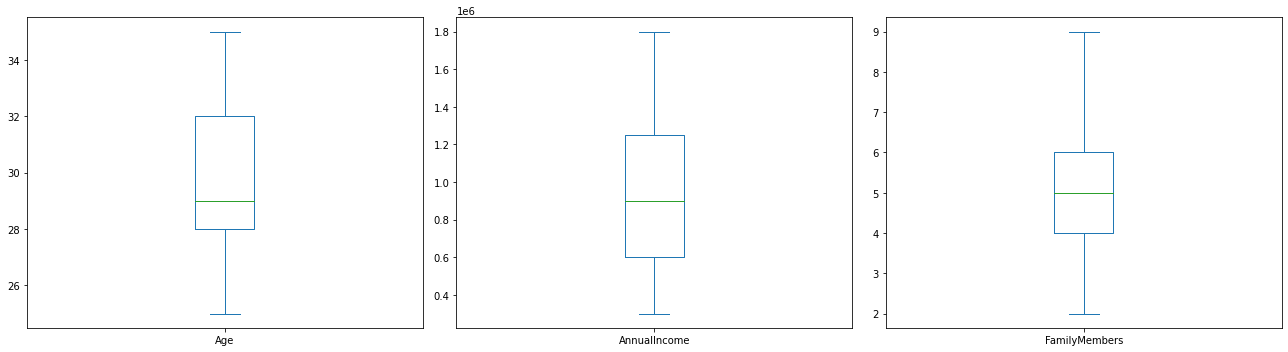

In [14]:
numeric_columns = data.select_dtypes(include=['int64', 'float64'])
non_binary_columns = numeric_columns.loc[:, numeric_columns.nunique() > 2]
num_rows_box = math.ceil(len(non_binary_columns.columns) / 3)

non_binary_columns.plot(
    kind='box', subplots=True, layout=(num_rows_box, 3),
    figsize=(18, num_rows_box * 5), sharex=False, sharey=False
)

plt.tight_layout()
plt.show()

- Box plots are consistant with previous distribution visualizations as well as with descriptive tables.

Will create correlation matrix using Kendall tau correlation. This method was chosen due to small size and ordinal nature of the dataset.

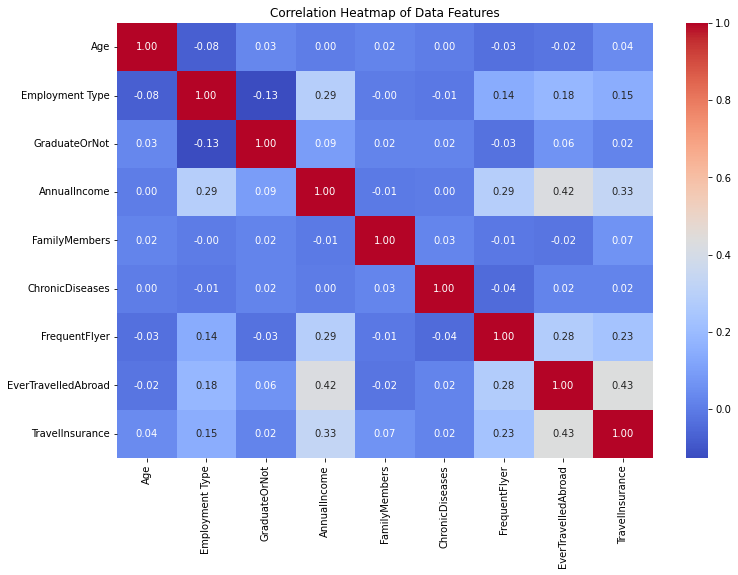

In [15]:
plt.figure(figsize=(12, 8))
corr_matrix = data.corr(method='kendall')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Data Features')
plt.show()

**Correlation heatmap suggests:**
- People with higher income tend to travel more
- People with higher income tend to buy insurance more

## Making predictions

- As mentioned previously, a large chunk of data are perfect duplicates; hence, ML models will be trained on both: original and deduplicated data.
- Will need to separate target feature from the dataset.
- Will split data into training and testing.
- And do the same for original and deduplicated data.

In [16]:
data_deduplicated = data.drop_duplicates()

X = data.drop('TravelInsurance', axis=1)
y = data['TravelInsurance']
X_deduplicated = data_deduplicated.drop('TravelInsurance', axis=1)
y_deduplicated = data_deduplicated['TravelInsurance']

print(f"Original Data: {data.shape}")
print(f"Deduplicated Data: {data_deduplicated.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_dd, X_test_dd, y_train_dd, y_test_dd = train_test_split(X_deduplicated, y_deduplicated, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_dd = scaler.fit_transform(X_train_dd)
X_test_dd = scaler.transform(X_test_dd)

Original Data: (1987, 9)
Deduplicated Data: (1249, 9)


**Models to be tested:**
- Logistic Regression  
- Decision Tree  
- Random Forest  
- Support Vector Machine (SVM)
- k-nearest neighbors (k-NN)

In [17]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'k-NN': KNeighborsClassifier()
}

In [18]:
results = []

print("Original Data Results:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred, report, cm = evaluate_model(model, X_test, y_test)
    for label in ['0', '1']:
        metrics = report[label]
        results.append({
            'Model': name,
            'Class': label,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score']
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1-Score', ascending=False)
results_df.head(len(results_df))

Original Data Results:


,Model,Class,Precision,Recall,F1-Score
6,SVM,0,0.773913,0.949333,0.852695
4,Random Forest,0,0.802885,0.890667,0.844501
2,Decision Tree,0,0.787952,0.872000,0.827848
0,Logistic Regression,0,0.742981,0.917333,0.821002
8,k-NN,0,0.766204,0.882667,0.820322
5,Random Forest,1,0.773481,0.630631,0.694789
3,Decision Tree,1,0.736264,0.603604,0.663366
7,SVM,1,0.861314,0.531532,0.657382
9,k-NN,1,0.733333,0.545045,0.625323
1,Logistic Regression,1,0.768657,0.463964,0.578652


- All models are better at predicting customers who didn't buy the package.
- SVM (Class 0) is the most accurate model with highest Recall and F1 scores.
- Random Forest (Class 0) is second most accurate model while Random Forest (Class 1) is the best among Class 1 models. 

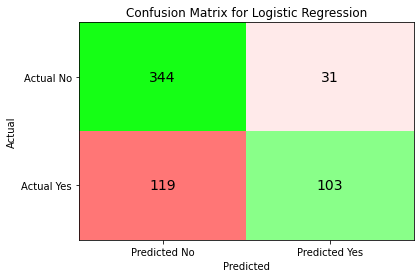

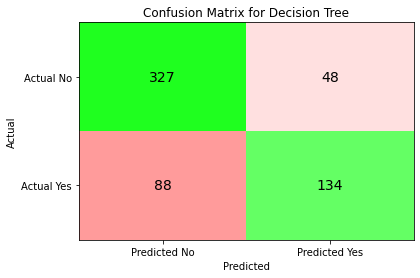

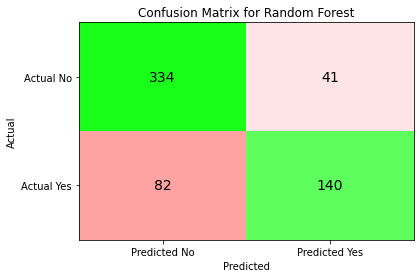

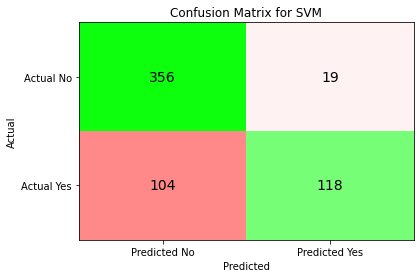

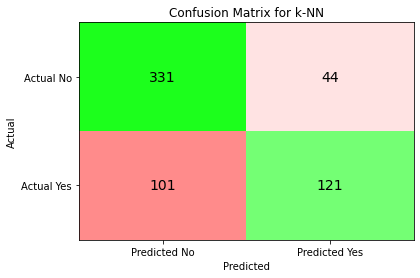

In [19]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred, _, cm = evaluate_model(model, X_test, y_test)
    plot_confusion_matrix(cm, f'Confusion Matrix for {name}')

Now will retrain all the models with deduplicated data.

In [20]:
results_dd = []

print("Deduplicated Data Results:")
for name, model in models.items():
    model.fit(X_train_dd, y_train_dd)
    y_pred_dd, report_dd, cm_dd = evaluate_model(model, X_test_dd, y_test_dd)
    for label in ['0', '1']:
        metrics = report_dd[label]
        results_dd.append({
            'Model': name,
            'Class': label,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score']
        })

results_df_dd = pd.DataFrame(results_dd)
results_df_dd = results_df_dd.sort_values(by='F1-Score', ascending=False)
results_df_dd.head(len(results_df))

Deduplicated Data Results:


,Model,Class,Precision,Recall,F1-Score
6,SVM,0,0.747440,0.948052,0.835878
0,Logistic Regression,0,0.706485,0.896104,0.790076
8,k-NN,0,0.730627,0.857143,0.788845
4,Random Forest,0,0.711382,0.757576,0.733753
2,Decision Tree,0,0.703540,0.688312,0.695842
7,SVM,1,0.853659,0.486111,0.619469
9,k-NN,1,0.682692,0.493056,0.572581
5,Random Forest,1,0.565891,0.506944,0.534799
3,Decision Tree,1,0.516779,0.534722,0.525597
1,Logistic Regression,1,0.707317,0.402778,0.513274


- Overall, deduplicated data models are less accurate than original data models.
- Model ranking remained the same.

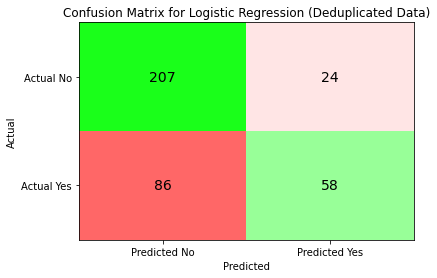

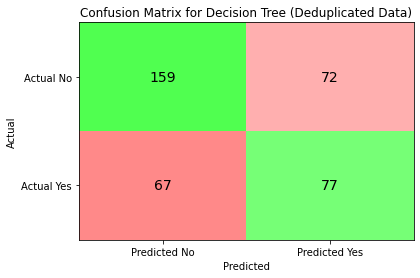

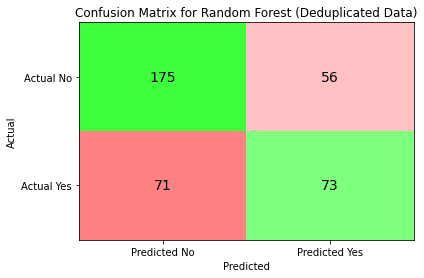

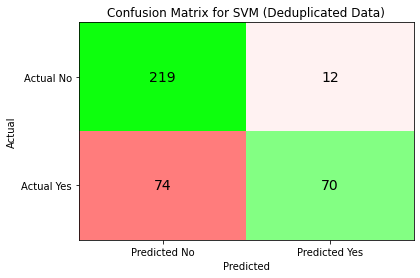

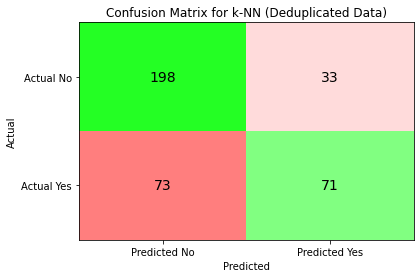

In [21]:
for name, model in models.items():
    model.fit(X_train_dd, y_train_dd)
    y_pred_dd, _, cm_dd = evaluate_model(model, X_test_dd, y_test_dd)
    plot_confusion_matrix(cm_dd, f'Confusion Matrix for {name} (Deduplicated Data)')

Somewhat significant differences in accuracy scores between original and deduplicated calls for these differences to be tested using statistical inference.

In [22]:
f1_scores_original = results_df[results_df['Class'] == '1']['F1-Score']
f1_scores_deduplicated = results_df_dd[results_df_dd['Class'] == '1']['F1-Score']

precision_original = results_df[results_df['Class'] == '1']['Precision']
precision_deduplicated = results_df_dd[results_df_dd['Class'] == '1']['Precision']

recall_original = results_df[results_df['Class'] == '1']['Recall']
recall_deduplicated = results_df_dd[results_df_dd['Class'] == '1']['Recall']

perform_paired_t_test('F1-Scores', f1_scores_original, f1_scores_deduplicated)
perform_paired_t_test('Precision', precision_original, precision_deduplicated)
perform_paired_t_test('Recall', recall_original, recall_deduplicated)

Paired t-test for F1-Scores: t-statistic = 9.131332895927889, p-value = 0.0007981140326898791
The difference in F1-Scores between the original and deduplicated data is statistically significant.
Paired t-test for Precision: t-statistic = 1.6535423009005454, p-value = 0.17356381238610924
The difference in Precision between the original and deduplicated data is not statistically significant.
Paired t-test for Recall: t-statistic = 2.7655812053210598, p-value = 0.050559411428528364
The difference in Recall between the original and deduplicated data is not statistically significant.


- To identify as many potential customers as possible, my analysis will prioritize maximing recall and f1 score instead of precision and that's why I'll continue using original dataset.
- Since Random Forest was the best perfomer in Class 1 and second-best performer in Class 0, it will be used to identify most important features.


Random Forest Classification Report:


,Class,Precision,Recall,F1-Score,Support
0,0,0.802885,0.890667,0.844501,375
1,1,0.773481,0.630631,0.694789,222


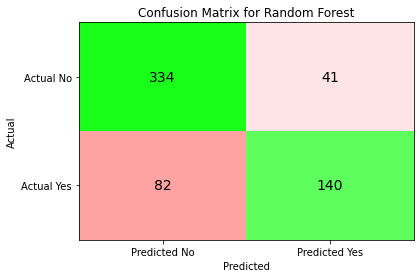

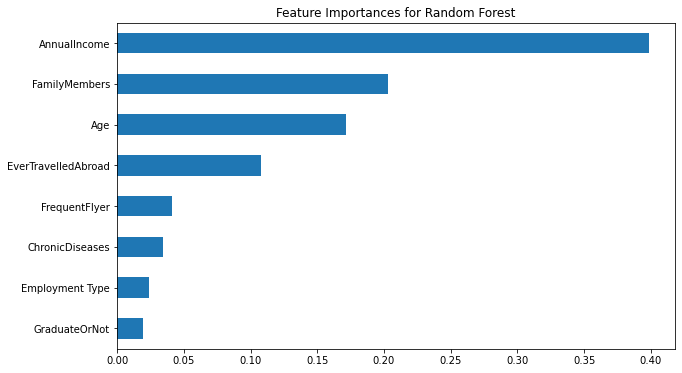

In [23]:
X_train = pd.DataFrame(X_train, columns=data.columns[:-1])
X_test = pd.DataFrame(X_test, columns=data.columns[:-1])

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

rf_model = train_random_forest(X_train, y_train)

y_pred_rf, report_rf, cm_rf = evaluate_model(rf_model, X_test, y_test)
display_classification_report(report_rf, "Random Forest Classification Report")
plot_confusion_matrix(cm_rf, 'Confusion Matrix for Random Forest')
plot_feature_importances(rf_model.feature_importances_, X_test.columns, 'Feature Importances for Random Forest')

Significant features:
- AnnualIncome
- FamilyMembers
- Age
- EverTravelledAbroad

In order to capture precision vs recall balance and find the best threshold ratio I'll visualize their relationship curve.

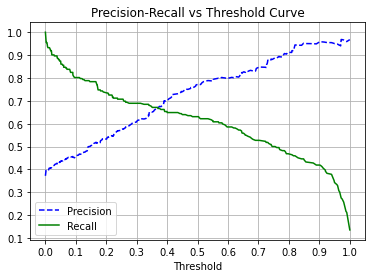

In [24]:
y_scores_rf = rf_model.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_scores_rf)

- Chart shows that around 0.35 threshold precision and recall lines meet.

- Now will retrain the model using only top 4 most significant features


Random Forest Classification Report (Significant Features):


,Class,Precision,Recall,F1-Score,Support
0,0,0.806846,0.880000,0.841837,375
1,1,0.760638,0.644144,0.697561,222


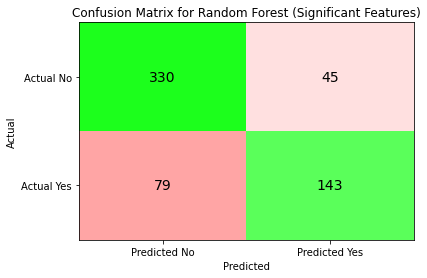

In [25]:
significant_features = ['AnnualIncome', 'FamilyMembers', 'Age', 'EverTravelledAbroad']

X_train_sig = X_train[significant_features]
X_test_sig = X_test[significant_features]

rf_model_sig = train_random_forest(X_train_sig, y_train)

y_pred_rf_sig, report_rf_sig, cm_rf_sig = evaluate_model(rf_model_sig, X_test_sig, y_test)
display_classification_report(report_rf_sig, "Random Forest Classification Report (Significant Features)")
plot_confusion_matrix(cm_rf_sig, 'Confusion Matrix for Random Forest (Significant Features)')

- Model with less features has slightly lower f1 and recall score while having better precision score.
- Model was also able to correctly identify 3 more true positives than previous model.

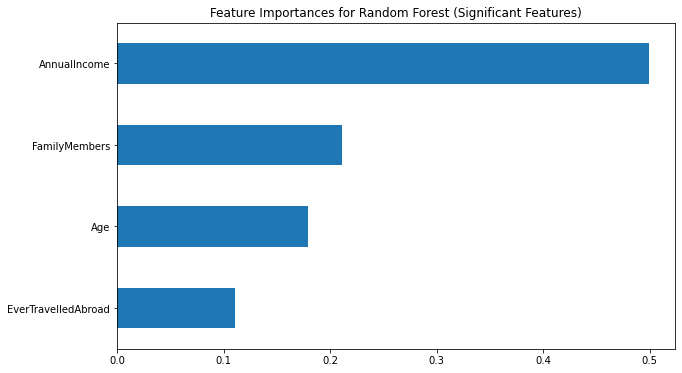

In [26]:
plot_feature_importances(rf_model_sig.feature_importances_, X_test_sig.columns, 'Feature Importances for Random Forest (Significant Features)')

- Distribution of feature importance ratio remains somewhat similar with AnnualIncome making up about 50%.

Once again, let's check precision vs recall curve.

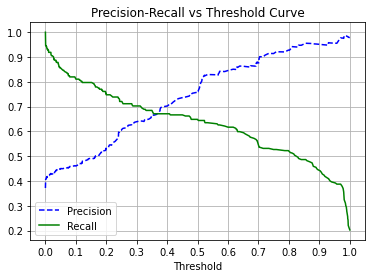

In [27]:
y_scores_rf_sig = rf_model_sig.predict_proba(X_test_sig)[:, 1]
plot_precision_recall_curve(y_test, y_scores_rf_sig)

- The curve is somewhat the similar as in previous chart.

### Hyperparameter tuning

- Now we'll select the most commonly used hyperparameter values for each model.
- These hyperparameter grids will be used to perform grid search and find the best combination of hyperparameters.

In [28]:
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
}

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

best_models = {}

In [29]:
for model_name, param_grid in param_grids.items():
    model = models[model_name]
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best {model_name}: {grid_search.best_params_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Random Forest: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best SVM: {'C': 10, 'kernel': 'rbf'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best K-Nearest Neighbors: {'n_neighbors': 7, 'weights': 'uniform'}


**Findings from grid search:**
- **Logistic Regression:** Works best with a C value of 1 and using the 'liblinear' method.
- **Decision Tree:** The best tree has a maximum depth of 10, splits nodes with at least 10 samples, and has at least 2 samples per leaf.
- **Random Forest:** The best forest has 300 trees, each tree can be 10 levels deep, uses the 'auto' setting for choosing features, splits nodes with at least 5 samples, and has at least 1 sample per leaf.
- **SVM:** The best model uses a C value of 10 and the 'rbf' method.
- **K-Nearest Neighbors:** Works best with 7 neighbors and 'uniform' weighting.

- Now I'll combine the best models into a Voting Classifier, which makes predictions based on the majority vote from previously created models.
- Below, we see the classification report and confusion matrix for the Voting Classifier.


Classification Report:


,Class,Precision,Recall,F1-Score,Support
0,0,0.780435,0.957333,0.859880,375
1,1,0.883212,0.545045,0.674095,222


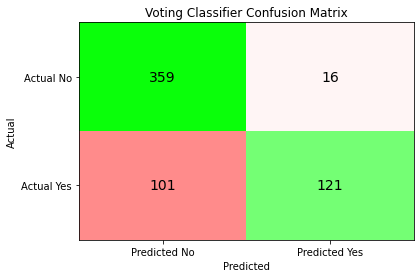

In [30]:
voting_clf = VotingClassifier(estimators=[
    ('lr', best_models['Logistic Regression']),
    ('dt', best_models['Decision Tree']),
    ('rf', best_models['Random Forest']),
    ('svm', best_models['SVM']),
    ('knn', best_models['K-Nearest Neighbors'])
], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred_voting, report_voting, cm_voting = evaluate_model(voting_clf, X_test, y_test)
display_classification_report(report_voting)
plot_confusion_matrix(cm_voting, title='Voting Classifier Confusion Matrix')

This model produced the best results statistically. However, out aim is to maximize number of true positives; hence, previous Random Forest model with top 4 features performed the best having 143 true positives.

### So what type of customers should be targeted?
- Frequent flyers
- Middle to high income customers
- Larger families

If all three of these requirements are met, customers are very likely to purchase additional insurance package. Surprisingly, chronic diseases are not as crucial factors as initially thought.

### So which is the best model?
Everything comes down to the cost of offering the insurance plan.
- **Low Cost:** If the cost is low, it's recommended to use the Random Forest model. This model considers only age, annual income, number of family members, and whether the customer is a frequent flyer. It's effective in maximizing the count of identified customers, making it a suitable choice when the financial risk is minimal.
- **High Cost:** If the cost is high, the Voting Classifier (a combination of multiple models) should be used for its accuracy. This approach ensures that predictions are more precise, which is crucial when the financial stakes are higher.

### Potential improvements
- Implement bootstraping to better account for small dataset.
- Get some new data to validate best performing model.
- Get better labeled date since it's difficult to assume what exactly is here.